In [1]:
import os
import random
from pathlib import Path
import sys

import numpy as np
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from transformers import (
    AutoTokenizer, Trainer, TrainingArguments,
)
from torchvision.models import ResNet152_Weights

sys.path.append('../')
from src.data.prepare import load_base_df
from src.models.MMBT.dataset import (BokeTextImageDataset, collate_fn)
from src.models.MMBT.mmbt import load_model
from src.models.utils import fix_seed, plot_confusion_matrix

In [2]:
SEED_SHUFFLE = 42
SEED_TRAIN = 0

## データ読み込み

In [3]:
train_df, test_df, submission_df = load_base_df('../dataset/csv/', '../dataset/imgs/')

In [4]:
print(f'train_df.shape: {train_df.shape}')
display(train_df.head())

print(f'test_df.shape: {test_df.shape}')
display(test_df.head())

train_df.shape: (24962, 5)


,id,odai_photo_file_name,text,is_laugh,img_path
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0,../dataset/imgs/train/9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0,../dataset/imgs/train/c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0,../dataset/imgs/train/whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0,../dataset/imgs/train/6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0,../dataset/imgs/train/0i9gsa2jsm.jpg


test_df.shape: (6000, 5)


,id,odai_photo_file_name,text,img_path,is_laugh
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ,../dataset/imgs/test/nc1kez326b.jpg,0
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！,../dataset/imgs/test/49xt2fmjw0.jpg,0
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹,../dataset/imgs/test/9dtscjmyfh.jpg,0
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??,../dataset/imgs/test/osa3n56tiv.jpg,0
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...,../dataset/imgs/test/yb1yqs4pvb.jpg,0


## データ準備, 学習

In [5]:
train_idx, valid_idx = train_test_split(list(range(len(train_df))), test_size=.2, random_state=SEED_SHUFFLE, stratify=train_df['is_laugh'])

In [6]:
MAX_SEQENCE_LEN = 48
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
train_ds = BokeTextImageDataset(train_df.iloc[train_idx], tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)
valid_ds = BokeTextImageDataset(train_df.iloc[valid_idx], tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)
test_ds = BokeTextImageDataset(test_df, tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)

In [7]:
# seed値の固定
fix_seed(SEED_TRAIN)
model = load_model()
MODEL_DST = Path('../model/mmbt_exp01')
EPOCHS = 3
BATCH_SIZE = 8
# BATCH_SIZEを1単位として、指定数分だけ勾配を貯めておき、その平均で勾配を更新する。
# 以下、参考
# - https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/trainer#transformers.TrainingArguments
# - https://qiita.com/cfiken/items/1de519e741cbbc09818c
# - https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/02/19/gradient-accumulation.html
GRADIENT_ACCUMULATION_STEPS = 20
SAVE_STEPS = 25
trainer_args = TrainingArguments(
    output_dir=str(MODEL_DST),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    num_train_epochs=EPOCHS,
    evaluation_strategy="steps",
    eval_steps=SAVE_STEPS,
    save_strategy="steps",
    save_steps=SAVE_STEPS,
    logging_steps=SAVE_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=12,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    load_best_model_at_end=True,
    logging_dir='./logs',
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainer_args,
    tokenizer=tokenizer,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    data_collator=collate_fn,
)

trainer.train()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using cuda_amp half precision backend
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning:

Step,Training Loss,Validation Loss
25,0.690600,0.660162
50,0.663200,0.657856
75,0.658000,0.671017
100,0.652200,0.647973
125,0.676500,0.646846
150,0.630200,0.646744
175,0.620100,0.657836
200,0.607500,0.669254
225,0.621900,0.651430
250,0.625200,0.657130


***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/mmbt_exp01/checkpoint-25
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/mmbt_exp01/checkpoint-25/tokenizer_config.json
Special tokens file saved in ../model/mmbt_exp01/checkpoint-25/special_tokens_map.json
Deleting older checkpoint [../model/mmbt_exp01/checkpoint-100] due to args.save_total_limit
Deleting older checkpoint [../model/mmbt_exp01/checkpoint-150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/mmbt_exp01/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/mmbt_exp01/checkpoint-50/tokenizer_config.json
Special tokens file saved in ../model/mmbt_exp01/checkpoint-50/special_tokens_map.json
Deleting older checkpoint [../model/mmbt_exp01/checkpoint-25] du

TrainOutput(global_step=372, training_loss=0.6054682834174043, metrics={'train_runtime': 1966.7777, 'train_samples_per_second': 30.459, 'train_steps_per_second': 0.189, 'total_flos': 0.0, 'train_loss': 0.6054682834174043, 'epoch': 2.99})

## 評価

In [10]:
# validationデータの予測値取得
val_preds = trainer.predict(valid_ds).predictions
# logg lossとaccuracy測定
loss = log_loss(valid_ds.df["is_laugh"].values, softmax(val_preds, axis=-1))
acc = accuracy_score(valid_ds.df['is_laugh'].values, np.argmax(val_preds, axis=-1))
print(f'log loss: {loss}')
print(f'accuracy: {acc}')

***** Running Prediction *****
  Num examples = 4993
  Batch size = 12


log loss: 0.6466776020608539
accuracy: 0.6238734227919087


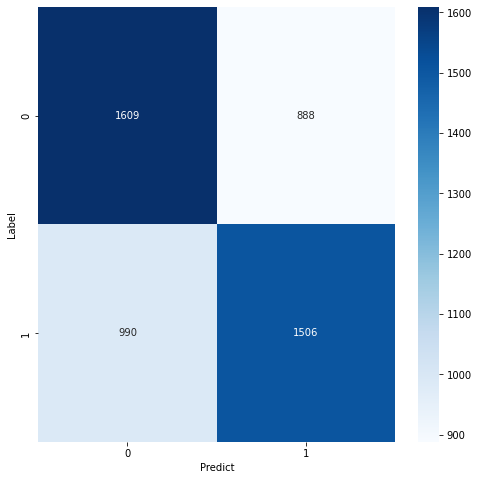

In [11]:
# 混同行列描画
plot_confusion_matrix(y_true=valid_ds.df['is_laugh'].values, y_pred=val_preds)

## テストデータの予測

In [12]:
y_pred = trainer.predict(test_ds).predictions

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


In [13]:
submission_df['is_laugh'] = softmax(y_pred, axis=1)[:, 1]
submission_df["is_laugh"] = submission_df["is_laugh"].astype(float)

In [14]:
output = '../results/submission_baseline.csv'
submission_df.to_csv(output, index=False)